In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import system #,container, setup
from scipy.signal import find_peaks


In [14]:
#functions to do the tests for all halmarks: frequency, intensity, potentiation, subliminal accumulation. 
#all functions are called from a function that receives a dict as argument, so the ones not suitable for a given function will be passed in the **kwargs
def execute_freq_sens(mys,T_scan_set=[],Amin=0, Amax=0, Ton=0,ht_threshold=0.01, recovery_threshold=0.95,**kwargs):
    #test for frequency sensitivity. Computes ht and rt ffor each period T in T_scan_set
    traj = []
    tvecs = []
    ht = []
    rt=[]
    recovery_traj = []
    for j, T in enumerate(T_scan_set): 
        ht_,rt_ = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold, recovery_threshold=recovery_threshold)
        ht.append(ht_)
        rt.append(rt_)
        print("A",Amax,"T",T,ht_,rt_)
        traj.append(mys.computational_data["trajectory"])
        tvecs.append(mys.computational_data["tvec"])
        recovery_traj.append(mys.computational_data["recovery_trajectory"])
    return [tvecs,traj, recovery_traj,ht,rt]

def execute_recovery_envelope(mys, height_peaks=0.001, T_scan_set=[],Amin=0, Amax=0, Ton=0,ht_threshold=0.01, recovery_threshold=0.95, idx_hab=-1,npoints=25,**kwargs):
    #Calculate response height at various post-habituation times
    peak_norm_Ts = []
    tperturblist_Ts = []
    for T in T_scan_set:
        ht, rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold,recovery_threshold=recovery_threshold)
        #tperturblist=np.linspace(T,rt,40) #times after habituation at which perturbation is applied, starting always from habituation time
        tperturblist = np.logspace(np.log10(T), np.log10(rt), npoints, endpoint=True)
        tperturblist_Ts.append(tperturblist)
        tvec=mys.computational_data["tvec"]
        htstep=mys.computational_data["habituation_time_step"]
       # trajectory=mys.computational_data["trajectory"][:htstep,:]
       # habituation_time=mys.computational_data["habituation_time"]
        times_envelope = []
        peaks_envelope = []
        for t in tperturblist:
            tvecr,recovery_trajectory=mys.integrate_posthabituation_atAmin(tend=t)
            perturbational_tvec, perturbational_trajectory = mys.apply_singlestimulus(recovery_trajectory[-1])
            output_var = perturbational_trajectory[:,idx_hab]
            peak, _ = find_peaks(output_var, height=height_peaks) #, height=0
            lista = output_var[peak]
            lista_times = perturbational_tvec[peak]
            peaks_envelope.append(lista[-1])
            
            all_tvec=tvec[:htstep].copy()
            all_tvec=np.concatenate((all_tvec,tvecr))
            times_envelope.append(lista_times[-1]+all_tvec[-1])
        peak_norm = np.array(peaks_envelope)/mys.computational_data['peaks_level'][0]
        peak_norm_Ts.append(peak_norm)
    return [tperturblist_Ts, peak_norm_Ts]


def execute_int_sens(mys,A_scan_set=[],Amin=0,T=0, Ton=0,ht_threshold=0.01, recovery_threshold=0.95,**kwargs):
    #intensity sensitivity
    traj = []
    tvecs = []
    ht = []
    rt=[]
    recovery_traj = []
    for Amax in A_scan_set: 
        ht_,rt_ = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold, recovery_threshold=recovery_threshold)
        ht.append(ht_)
        rt.append(rt_)
        print("T",T, "A",Amax,ht_,rt_)
        traj.append(mys.computational_data["trajectory"])
        tvecs.append(mys.computational_data["tvec"])
        recovery_traj.append(mys.computational_data["recovery_trajectory"])
    return [tvecs,traj, recovery_traj,ht,rt]

def plot_trajectories(tvecs, traj, recovery_traj,ht,rt, idxs=dict(),vartitles=dict(), T_scan_set=[], A_scan_set=[],Tis=0, Sfs=0,variables_toplot=[], 
                      Ms_toplot=["M1","M2"],kind="freqs",offsets=[0.95,1,1.05],colors=[],steps_per_time=100,zorder=[1,2,3],xlimrec=0,xlimrec2=0,ylims=0,savepath=None,**kwargs):
    print("in plot trajectories, variables to plot", variables_toplot)
    if not kind in ["freqs", "ints"]:
        raise ValueError("kind should be freqs or ints")
    
    if len(variables_toplot)==2: #tailored for our models that either have 3 or 6 variables, and we plot 3-1 or 6-1
        nrows=1
    else:
        nrows=2
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(8, 2*nrows))
    figinset,axinset=plt.subplots(1,1,figsize=(2,2))
    if nrows==1:
        ax0=axes[0]
        axes_l=[axes[1], axes[2]]
        axesm=[axes[3]]
    else:
        ax0=axes[0][0]
        axes_l=[axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]]
        axesm=[axes[0][3],axes[1][3]]
    
    for i in range(len(traj)): #for the various freq or is
    
        #stimulus:
        ax = ax0 
        if kind=="freqs":
            offset=offsets[i]
            T=T_scan_set[i]
            x_t_stimuli=np.arange(0,ht[i]*T+ht[i],T) #time points at which the stimuli are applied, from 0 until ht (in stimulus number)
            ax.scatter(x_t_stimuli,[Sfs*offset]*len(x_t_stimuli),marker=".",color=colors[i],s=2)
        else:
            T=Tis
            x_t_stimuli=np.arange(0,ht[i]*T+ht[i],T)
            ax.scatter(x_t_stimuli,[A_scan_set[i]]*len(x_t_stimuli),marker=".",color=colors[i],s=2)
        ax.set_xlabel("time (a.u.)")
        ax.set_ylabel("S")
        if i==2:
            print("setting ylims", ylims)
            ax.set_ylim(0,ylims)
        
        
        #now plot the rest    
        for v,variable in enumerate(variables_toplot):
            ax=axes_l[v]
            if variable in idxs.keys():
                idx=idxs[variable]

                x = tvecs[i][:ht[i]*T*steps_per_time]/T+1 # no of stimuli
                y = traj[i][:ht[i]*T*steps_per_time,idx] #trajectory data for this freq or intensity
                ax.plot(x, y, color = colors[i],zorder=zorder[i])

                ax.set_title(vartitles[variable])
                if v==0 or v==3:
                    ax.set_ylabel("active fraction")
                ax.set_xlabel('no. of stimuli')
                if i==2:
                    ax.set_ylim(0,)

        # M recovery
        for v,variable in enumerate(Ms_toplot):
            if variable in idxs.keys():
                ax = axesm[v]
                y = recovery_traj[i][:,idxs[variable]]
                x = np.arange(0,len(y))/steps_per_time
                ax.plot(x, y, color = colors[i])
                ax.set_title("%s (recovery)"%vartitles[variable])
                ax.set_xlim(0,xlimrec)
                ax.set_xlabel('post-hab. time (a.u.)')
                if i==2:
                     ax.set_ylim(0,)
        
        variable=Ms_toplot[0]
        #M recovery, inset
        y = recovery_traj[i][:,idxs[variable]]
        x = np.arange(0,len(y))/steps_per_time
        axinset.plot(x, y, color = colors[i])
        axinset.set_xlim(0,xlimrec2)
        if i==2:
            axinset.set_ylim(0,)
            axinset.spines['top'].set_visible(False)
            axinset.spines['right'].set_visible(False)
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.tight_layout(w_pad=0.1)
    
    if savepath:
        fig.savefig(savepath,bbox_inches="tight")
        figinset.savefig(savepath+"inset.pdf",bbox_inches="tight")
        
    plt.show()
    
        
    
def plot_freq_or_is(tvecs, traj, recovery_traj,ht,rt,idx_hab=0, T_scan_set=[], A_scan_set=[], 
                      kind="freqs",colors=[],steps_per_time=100,zorder=[1,2,3],savepath=None,Tis=0, Sfs=0,idxs=dict(),vartitles=dict(),normalisedto0=False,**kwargs):
    
    if idx_hab<0:
        raise ValueError("idx_hab should be positive")
    idxs_rev={v:k for k,v in idxs.items()} #idxs has as key: variable name and as value: index. Here we are reversing this so we have as keys the index
    varname=vartitles[idxs_rev[idx_hab]] #this gives the formatted latex variable name e.g. idx_hab=5--> R2--> $R_2$
    if not kind in ["freqs", "ints"]:
        raise ValueError("kind should be freqs or ints")
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    for i in range(len(traj)):
        if kind=="freqs":
            title="frequency sensitivity"
            A=Sfs
            T=T_scan_set[i]
            label='T=%g, ht=%d, rt=%2.1f'%(T, ht[i], rt[i])
            y = traj[i][:ht[i]*T*steps_per_time,idx_hab]
            x = tvecs[i][:ht[i]*T*steps_per_time]/T+1 # no of stimuli
        else:
            title="intensity sensitivity"
            T=Tis
            y = traj[i][:ht[i]*T*steps_per_time,idx_hab]
            x = tvecs[i][:ht[i]*T*steps_per_time]/T+1 # no of stimuli
            A=A_scan_set[i]
            label="A=%g, ht=%d, rt=%2.1f"%(A, ht[i], rt[i])
        if normalisedto0:
            y=y/max(y[0:T*steps_per_time])
            ylabel="normalised %s"%varname
        else:
            ylabel='%s (active fraction)'%varname
        ax.plot(x, y,color = colors[i], lw=1+0.5*i,label=label,zorder=zorder[i])
        ax.set_xlabel('no. of stimuli')
        ax.set_ylabel(ylabel)
        ax.set_title(title)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend()
    plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()

def plot_recovery_envelope(tperturblist_Ts, peak_norm_Ts, T_scan_set=[], A_scan_set=[], 
                            colors=[],steps_per_time=100,zorder=[1,2,3],savepath=None,**kwargs):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
    for i,T in enumerate(T_scan_set):
        title="recovery envelope"
        ax.plot(tperturblist_Ts[i], peak_norm_Ts[i],  "-",marker="o",ms=2, color = colors[i], lw=1+0.5*i, label="T=%d"%T, zorder=zorder[i])
    
        ax.set_xlabel("Single stimulus application time (since ht)")
        ax.set_ylabel("Single stimulus peak/ first peak")
        ax.set_title(title)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.axhline(y=0.95, color="gray", alpha=1.0, ls="--", label = "y=0.95")
    plt.legend()
    plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()           
    
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
def plot_recovery_envelope_withmemories(tperturblist_Ts, peak_norm_Ts, tvecs, recovery_traj,T_scan_set=[], Ms_toplot=[],idxs=dict(),
                            colors=[],steps_per_time=100,zorder=[1,2,3],savepath=None,xlim=None,**kwargs):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
    axm1=ax.twinx()
    axm2=ax.twinx()
    axm2.spines["right"].set_position(("axes", 1.2))
    make_patch_spines_invisible(axm2)
    axm2.spines["right"].set_visible(True)
    axm=[axm1,axm2]
    title="recovery"
    ax.set_title(title)
    maxx_l=[]
    for i,T in enumerate(T_scan_set):
        
        ax.plot(tperturblist_Ts[i], peak_norm_Ts[i],  "-", color = colors[i], lw=1+0.5*i, label="T=%d"%T, zorder=zorder[i]*3)
        maxx=max(tperturblist_Ts[i])
        ax.set_xlabel("post-habituation time (a.u.)")
        ax.set_ylabel("test peak/first peak")
        maxx_l.append(maxx)
    maxx=max(maxx_l)
    for i,T in enumerate(T_scan_set):
        for v,variable in enumerate(Ms_toplot):
            if variable in idxs.keys():
                y = recovery_traj[i][:,idxs[variable]].copy()
                y=y[0:int(maxx*steps_per_time)]
                max_y=max(y)
                
                
                x = np.arange(0,len(y))/steps_per_time
                ls=["--",":"][v]
                
                axm[v].plot(x, y, color = colors[i],linestyle=ls)
                if ls==":":
                        ls="···"
                if v==0:
                    try:
                        #plot a vertical line where the first memory has decayed by 95%
                        xind=np.where(y<(0.05*max_y))[0][0] 
                        print(T,variable,x[xind])
                        axm[v].axvline(x=x[xind],linestyle="--",color="gray",linewidth=1)
                    except:
                        print("could not find xind for %s %d"%(variable, T))
                    
                axm[v].set_ylabel("%s%s%s"%(ls,ls,variable))
                

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(y=0.95, color="gray", alpha=1.0, ls="--")
    ax.legend(loc="upper right")   
    ax.set_xlim(0,xlim)
    ax.text(0,0.95,"rec. thr = 0.95 ",horizontalalignment="right")
    
    plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()           
    
    
            
            
def potentiation(f=None,p0=[],X0=[],idx_hab=-1,idxM_pot=-2,T=0,Ton=0,Amin=0,Amax=0,ht_threshold=0.01,recovery_threshold=0.95,
                 steps_per_time=100,rt_fraction=0.5,color='k',savepath=None,vartitles=dict(),idxs=dict(),hmax=0,printpotstatsonly=False,**kwargs):
    if idx_hab<0 or idxM_pot<0:
        raise ValueError("idx_hab and idxM_pot should be positive")
    
    idxs_rev={v:k for k,v in idxs.items()}
    idxM=idxM_pot
    varname_M=vartitles[idxs_rev[idxM]]
    varname_R=vartitles[idxs_rev[idx_hab]]
    # first train of stimuli
    mys = system.System(f,p0, X0,output_var_idx=idx_hab,steps_per_time=steps_per_time,hmax=hmax)
    ht,rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold,recovery_threshold=recovery_threshold)
    traj = mys.computational_data["trajectory"][:int(ht*T*steps_per_time)]
    peak = mys.computational_data['peaks_level'][ht]

    # recovery trajectory
    print("A", Amax, "T", T, "rt", rt, "time at which new train applied is", int(rt_fraction*int(rt)))
    recovery_traj = mys.computational_data['recovery_trajectory'][:int(rt_fraction*int(rt))*steps_per_time,:]

    # second train of stimuli starting from the partially recovered state
    X1 = recovery_traj[-1] # extract new initial condition
    X1[X1 < 0] = 0 # prevent negative blowup
    mys = system.System(f,p0, X1,output_var_idx=idx_hab,steps_per_time=steps_per_time,hmax=hmax)
    ht2,rt2 = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold,recovery_threshold=recovery_threshold)
    traj2 = mys.computational_data["trajectory"][:int(ht2*T*steps_per_time)]
    peak2 = mys.computational_data['peaks_level'][ht2]
    
    
    if ht2<ht:
        ok=True
    else:
        ok=False
    print(ok,"ht:", ht, "ht2:", ht2, "rt:", rt, "rt2:", rt2)
    print("amplitude last peak train 1:", max(traj[-T*steps_per_time:, idx_hab]), "train 2:", max(traj2[-T*steps_per_time:,idx_hab]))
    
    if printpotstatsonly:
        return 
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 1))
    ax = axes
    axt=ax.twinx()
    y = np.concatenate([np.array(traj), np.array(recovery_traj), np.array(traj2)])
    x = np.arange(0,len(y))/steps_per_time

    axt.plot(x,y[:,idxM], color="gray", lw=1.5, alpha=0.5,label=varname_M) # Memory
    ax.plot(x,y[:,idx_hab], color=color,label=varname_R) # Response
    

    ax.axvline(x=ht*T, linestyle='--', color=color) #label='ht = '+str(ht))
    xval=(ht+ht2)*T+int(int(rt)*rt_fraction)
    ax.axvline(x=xval, linestyle='--', color='gray')
    
    yval=max(ax.get_yticks())
    ax.text(ht*T, yval, "ht=%g"%ht,horizontalalignment='center')
    ax.text(xval, yval, "ht=%g"%ht2,horizontalalignment='center')
    #ax.plot((ht-1)*T, peak, 'o', color='black', label='ht = '+str(ht))
    #ax.plot((ht-1+ht2)*T+int(int(rt)*rt_fraction), peak, 'o', color='grey', label='ht = '+str(ht2))
    ax.set_xlabel('time (a.u.)')
    ax.set_ylabel('%s active fraction'%varname_R,color=color)
    axt.set_ylabel('%s active fraction'%varname_M,color="gray")
    axt.tick_params(axis='y', colors='gray')
    axt.spines['right'].set_color('gray')
    ax.spines['top'].set_visible(False)
    axt.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.legend(ncol=1,loc="upper center")
    #sns.despine()
    #plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()
    
def subliminal(f=None,p0=[],X0=[],idx_hab=-1,idxM_pot=-2,T=0,Ton=0,Amin=0,Amax=0,ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
                 steps_per_time=100,color='k',savepath=None,hmax=0,idxs=dict(),vartitles=dict(),printsubstatsonly=False,**kwargs):
    
    if idx_hab<0 or idxM_pot<0:
        raise ValueError("idx_hab and idxM_pot should be positive")
    idxs_rev={v:k for k,v in idxs.items()}
    idxM=idxM_pot
    varname_M=vartitles[idxs_rev[idxM]]
    varname_R=vartitles[idxs_rev[idx_hab]]
    mys = system.System(f,p0, X0,output_var_idx=idx_hab,steps_per_time=steps_per_time,hmax=hmax)

    # original system
    ht,rt=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold1,recovery_threshold=recovery_threshold)
    traj = mys.computational_data['trajectory'][:int(ht*T*steps_per_time)]
    recovery = mys.computational_data['recovery_trajectory'][:int(rt*steps_per_time)]
    recovered_peak = mys.computational_data['perturbational_trajectory'][round(rt-0.01, 2)].tolist()

    # system with more peaks (low ht threshold)
    ht2,rt2=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold2,recovery_threshold=recovery_threshold)
    traj2 = mys.computational_data['trajectory'][:ht2*T*steps_per_time,:]
    recovery2 = mys.computational_data['recovery_trajectory'][:int(rt2*steps_per_time),:]
    recovered_peak2 = mys.computational_data['perturbational_trajectory'][round(rt2-0.01, 2)].tolist()
    # plot 
    
    if rt2>rt:
        ok=True
    else:
        ok=False
    print(ok,"ht:", ht, "ht2:", ht2, "rt:", rt, "rt2:", rt2)
    
    if printsubstatsonly:
        return 
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,2),sharex=True, sharey=True)

    y = np.concatenate([np.array(traj), np.array(recovery), np.array(recovered_peak)])
    x = np.arange(0, len(y))/steps_per_time

    y2 = np.concatenate([np.array(traj2), np.array(recovery2), np.array(recovered_peak2)]) #stimulation beyond habituation
    x2 = np.arange(0, len(y2))/steps_per_time
    ax=axes[1]
    axt=ax.twinx()
    axt.plot(x2, y2[:,idxM], color='grey', alpha=0.5) #Memory
    ax.plot(x2, y2[:,idx_hab], color=color) #Response
    #axt.set_ylabel('%s active fraction'%varname_M,color='gray')
    axt.tick_params(axis='y', colors='gray')
    axt.spines['right'].set_color('gray')
    axt.spines['top'].set_visible(False)
    #ax.set_ylabel('%s active fraction'%varname_R,color=color)
    ax.spines['top'].set_visible(False)
    
    ax=axes[0]
    axt=ax.twinx()
    axt.plot(x, y[:,idxM], color='gray', alpha=0.5,label=varname_M) #Memory
    #axt.set_ylabel('%s active fraction'%varname_M,color='gray')
    axt.spines['top'].set_visible(False)
    axt.spines['right'].set_color('gray')
    axt.tick_params(axis='y', colors='gray')
    ax.plot(x, y[:,idx_hab], color=color, label=varname_R) #Response
    #ax.set_ylabel('%s active fraction'%varname_R,color=color)
    ax.spines['top'].set_visible(False)
    #ax.legend()

    # add rt description
    ax=axes[0]
    #ax.errorbar(ht*T+rt/2, 0.001, xerr=rt/2,
    #            color="lightgray",lw=14, alpha=0.4)
    ax.axvline(x=ht*T, linestyle="--",color=color)
    ax.text(ht*T+rt, 0.0001, 'rt = '+str(round(rt)), fontsize=12,horizontalalignment="right")
    #         color=colors[0], weight='bold')
    ax=axes[1]
    #ax.errorbar(ht2*T+rt2/2, 0.001, xerr=rt2/2,
    #            color='lightgray',lw=14, alpha=0.4)
    ax.text(ht2*T+rt2, 0.0001, 'rt = '+str(round(rt2)), fontsize=12,horizontalalignment="right")
    ax.axvline(x=ht*T, linestyle="--",color=color)
    ax.set_xlabel('time (a.u.)')
    fig.text(0.02,0.5,'%s active fraction'%varname_R,rotation=90,color=color,verticalalignment="center")
    fig.text(0.97,0.5,'%s active fraction'%varname_M,color='gray',rotation=90,verticalalignment="center")

    #
    #fig.text(0.55, 0.8, 'rt = '+str(round(rt2)), fontsize=12, 
    #         color='black', alpha=0.6, weight='bold')
    
    #plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()

def sensitivity(inputdatatxt,labels,savepath=None):
    f=open(inputdatatxt)
    data=[]
    for line in f:
        e=line.strip()
        col=line.split()
        data.append(col)
    data_float=[]
    for i in data:
        data_float.append([float(i[0]), float(i[1])])
        
    positive_data = []
    negative_data = []
    for i in data_float:
        positive_data.append(i[0])
        negative_data.append(i[1])
    threshold=0
    x=labels
    xmax=len(x)+0.5
    
    fig, ax = plt.subplots(1,1,figsize=(6,3))

    ax.bar(x, negative_data, width=0.5, color='grey')
    ax.bar(x, positive_data, width=0.5, color='grey')

    # horizontal line indicating the threshold
    ax.plot([-0.5, xmax], [threshold, threshold], 'w', lw="1.5")
    plt.hlines(0.25, -0.5, xmax, color='grey', alpha=0.5)
    plt.hlines(0.5, -0.5, xmax, color='grey', alpha=0.5)
    plt.hlines(0.75, -0.5, xmax, color='grey', alpha=0.5)
    plt.hlines(1.0, -0.5, xmax, color='grey', alpha=0.5)
    plt.hlines(-0.25, -0.5, xmax, color='grey', alpha=0.5)
    plt.hlines(-0.5, -0.5, xmax, color='grey', alpha=0.5)
    plt.hlines(-0.75, -0.5, xmax, color='grey', alpha=0.5)
    plt.hlines(-1.0, -0.5, xmax, color='grey', alpha=0.5)
    plt.xticks() #rotation = 45)
    plt.ylabel(r"log$_{10}$ perturbation")
    ax.set_xlim(-0.5,xmax-1)
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()

In [15]:
def execute_and_plot(kwargs):
    f=kwargs["f"]
    #mys=kwargs["mysystem"]
    X0=kwargs["X0"]
    p0=kwargs["p0"]
    Sfs=kwargs["Sfs"]
    Tis=kwargs["Tis"]
    
    labels_pars=kwargs["labels_pars"]
    
    folder=kwargs["folder"]
    basename=kwargs["basename"]
    
    sensdata=kwargs["sensdatatxt"]
    
    colorsf=kwargs["colorsf"]
    colorsi=kwargs["colorsi"]
    height_peaks_r=kwargs["height_peaks_r"]
    
    if not "offsets" in kwargs.keys():
        kwargs["offsets"]=[0.95,1,1.05]
    
    xlimrecfs1=kwargs["xlimrecfs1"]
    xlimrecfs2=kwargs["xlimrecfs2"]
    xlimrecis1=kwargs["xlimrecis1"]
    xlimrecis2=kwargs["xlimrecis2"]
    xlimrecenv=kwargs["xlimrecenv"]
    
    
    T_A_pot=kwargs["T_A_pot"]
    rtf_pot=kwargs["rtf_pot"]
    
    T_A_subliminal=kwargs["T_A_subliminal"]
    
    dosensitivity=kwargs["dosensitivity"]
    dofreqsensitivity=kwargs["dofreqsensitivity"]
    dorecovery=kwargs["dorecovery"]
    doisensitivity=kwargs["doisensitivity"]
    dopot=kwargs["dopot"]
    dosubliminal=kwargs["dosubliminal"]
    
    
    mys = system.System(f,p0, X0,output_var_idx=kwargs["idx_hab"],steps_per_time=kwargs["steps_per_time"],hmax=kwargs["hmax"])
    
    if dosensitivity:
    
        print("sensitivity analysis")
        namesave="%s_sens.pdf"%basename
        savepath=os.path.join(folder,namesave)
        sensitivity(sensdata,labels_pars,savepath=savepath)

    if dofreqsensitivity or dorecovery:
        print("Frequency sensitivity")
        
        output = execute_freq_sens(mys,Amax=Sfs, **kwargs)
    
    if dofreqsensitivity:
        namesave="%s_freqs.pdf"%basename
        savepath=os.path.join(folder,namesave)
        zorder=range(1,len(colorsf)+1)[::-1] #(3,2,1)
        plot_freq_or_is(*output, kind="freqs",colors=colorsf,zorder=zorder,savepath=savepath,**kwargs)

        namesave="%s_freqs_traj.pdf"%basename
        savepath=os.path.join(folder,namesave)
        plot_trajectories(*output, kind="freqs",colors=colorsf,
                          zorder=zorder,xlimrec=xlimrecfs1,xlimrec2=xlimrecfs2,ylims=Sfs*1.1,savepath=savepath,**kwargs)
    if dorecovery:
        #this uses output variable from execute_freq_sens
        print("Recovery envelope")
        tperturblist_Ts, peak_norm_Ts = execute_recovery_envelope(mys, height_peaks=height_peaks_r,Amax=Sfs, **kwargs)
        zorder=range(1,len(colorsf)+1)[::-1] #(3,2,1)
        
        namesave="%s_rec_env.pdf"%basename
        savepath=os.path.join(folder,namesave)
        
        plot_recovery_envelope_withmemories(tperturblist_Ts, peak_norm_Ts, output[0], output[2],
                                            colors=colorsf,zorder=zorder,savepath=savepath,**kwargs)
        
        namesave="%s_rec_env_xlim.pdf"%basename
        savepath=os.path.join(folder,namesave)
        plot_recovery_envelope_withmemories(tperturblist_Ts, peak_norm_Ts, output[0], output[2],
                                             xlim=xlimrecenv,colors=colorsf,zorder=zorder,savepath=savepath,**kwargs)


    if doisensitivity:
        if basename=="cNF":
            mys = system.System(f,p0, X0,output_var_idx=idx_hab,steps_per_time=steps_per_time,hmax=0.01) #otherwise it fails if hmax=0
        print("Intensity sensitivity")
        namesave="%s_ints.pdf"%basename
        savepath=os.path.join(folder,namesave)
        output = execute_int_sens(mys,T=Tis, **kwargs)
        zorder=range(1,len(colorsi)+1)[::-1] #(3,2,1)
        plot_freq_or_is(*output,kind="ints",colors=colorsi,zorder=zorder,savepath=savepath,**kwargs)
        
        #now normalised to the first peak
        namesave="%s_ints_norm.pdf"%basename
        savepath=os.path.join(folder,namesave)
        plot_freq_or_is(*output,kind="ints",colors=colorsi,zorder=zorder,savepath=savepath,normalisedto0=True,**kwargs)

        #rest of trajectories
        namesave="%s_ints_traj.pdf"%basename
        savepath=os.path.join(folder,namesave)
        plot_trajectories(*output, kind="ints",colors=colorsi,
                          zorder=zorder,xlimrec=xlimrecis1,xlimrec2=xlimrecis2,ylims=None,savepath=savepath,**kwargs)
    if dopot:
        print("Potentiation")
        for T_A in T_A_pot:
            T,A=T_A
            print("T", T, "A", A)
            
            namesave="%s_pot_%g_T=%g_A=%g.pdf"%(basename, rtf_pot, T, A)
            savepath=os.path.join(folder,namesave)
            potentiation(T=T, Amax=A,rt_fraction=rtf_pot,savepath=savepath,color=colorsf[0],**kwargs)
    if dosubliminal:
        print("Subliminal")
        for T_A in T_A_subliminal:
            T,A=T_A
            print("T", T, "A", A)

            namesave="%s_sub_T=%g_A=%g.pdf"%(basename, T, A)
            savepath=os.path.join(folder,namesave)
            subliminal(T=T, Amax=A, savepath=savepath,color=colorsf[0],**kwargs)

In [16]:
colorsf = ['#002138', '#3C78A8', '#8BBEDE'] #from dark to light
colorsi=['#002138', '#3F7234', '#A4BA35'] #from dark to light
folder="../../habituation/2023_paper/figs/panels"
labels_vars={"I1":"$I_1$", "I2":"$I_2$", "M1":"$M_1$", "M2":"$M_2$", "R1":"$R_1$", "R2":"$R_2$", "Ri":"$R_i$", "Rr":"$R_r$", "Ra":"$R_a$",
            "C1":"$C_1$", "C2":"$C_2$", "C3":"$C_3$"}

# Concatenated Incoherent Feedforward model

In [17]:
#IFF
def f_iFF(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2, K_2): 
    # starting values 
    I1, M1, R1, I2, M2, R2 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    dI2 = R1*kIa2*(1.0-I2) - kIi2*I2
    dM2 = I2*kMa2*(1.0-M2) - kMi2*M2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2/(K_2+R2)

    return(dI1, dM1, dR1, dI2, dM2, dR2)

# set parameters
 
X0=[0,0,0,0,0,0]
p0=[0.023, 34.44, 17.7071, 0.038241, 57.9236, 1.39117, 0.000534, 
            0.016011, 14.3342,  4.33609, 0.001471, 26.1702, 45.9986, 0.79082] #only rates and ODE parameters
idx_hab=5
idxs_M=[1,4]
idxM_pot=4


steps_per_time = 100

#mys = system.System(f_iFF,p0, X0,output_var_idx=idx_hab,steps_per_time=steps_per_time,hmax=0)

Sfs=10
T_scan_set = [15,20,25]
Tis=15
A_scan_set=[10,20,30]


labels_pars=[r"$k_{Ia1}$", r"$k_{Ii1}$",r"$k_{Ma1}$",r"$k_{Mi1}$",r"$k_{Ra1}$",r"$k_{Ri1}$",r"$K_{R1}$",r"$k_{Ma2}$",r"$k_{Mi2}$",r"$k_{Ra2}$",r"$k_{Ri2}$",r"$K_{R2}$",r"$k_{Ia2}$",r"$k_{Ii2}$"]

kwds=dict()
kwds["f"]=f_iFF
kwds["hmax"]=0
kwds["basename"]="cIFF"
kwds["X0"]=X0
kwds["p0"]=p0
kwds["T_scan_set"]=T_scan_set
kwds["offsets"]=[0.95,1,1.05,1.11]
kwds["A_scan_set"]=A_scan_set
kwds["Sfs"]=Sfs
kwds["Tis"]=Tis
kwds["Ton"]=1.11 #numbers change a bit if it is 1.1111111112 or 1.11
kwds["idx_hab"]=idx_hab
kwds["idxs_M"]=idxs_M #idxs of first and second memory species
kwds["Ms_toplot"]=["M1","M2"] #plot in recovery plot
kwds["variables_toplot"]=["I1", "M1", "R1", "I2", "M2"]
kwds["idxs"]={"I1":0, "M1":1, "R1":2, "I2":3, "M2":4, "R2":5}
kwds["labels_pars"]=labels_pars
kwds["vartitles"]=labels_vars

kwds["ht_threshold"]=0.01
kwds["recovery_threshold"]=0.95
kwds["height_peaks_r"]=0.001
kwds["folder"]=folder

kwds["idxM_pot"]=idxM_pot

kwds["ht_threshold2"]=0.005
kwds["sensdatatxt"]="./sensitivity_feedforward_concat/sensitivity_feedforward.txt"

kwds["colorsf"]=colorsf
kwds["colorsi"]=colorsi
kwds["steps_per_time"]=steps_per_time
kwds["xlimrecfs1"]=2000
kwds["xlimrecfs2"]=200
kwds["xlimrecis1"]=2000
kwds["xlimrecis2"]=200
kwds["xlimrecenv"]=200

kwds["T_A_pot"]=[[T_scan_set[0],A_scan_set[0]]]
kwds["T_A_subliminal"]=[[T_scan_set[0],A_scan_set[0]]]
kwds["rtf_pot"]=0.5
    
kwds["dosensitivity"]=True
kwds["dofreqsensitivity"]=True
kwds["dorecovery"]=True
kwds["doisensitivity"]=True
kwds["dopot"]=True
kwds["printpotstatsonly"]=False
kwds["dosubliminal"]=True
kwds["printsubstatsonly"]=False

sensitivity analysis


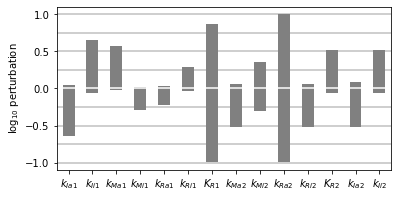

Frequency sensitivity
A 10 T 15 14 1558.39
A 10 T 20 22 1923.69
A 10 T 25 25 2072.27


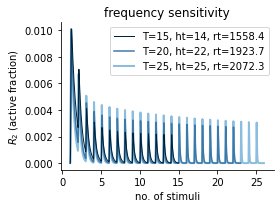

in plot trajectories, variables to plot ['I1', 'M1', 'R1', 'I2', 'M2']
setting ylims 11.0


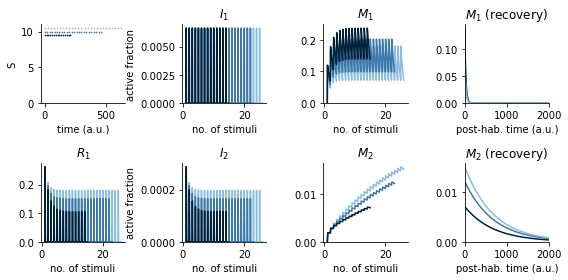

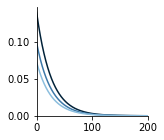

Recovery envelope
15 M1 78.34
20 M1 78.34
25 M1 78.34


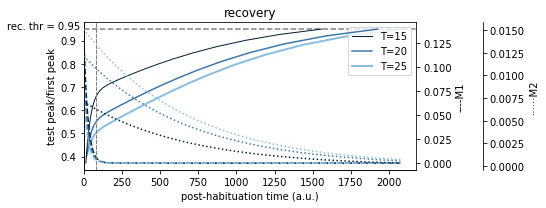

15 M1 78.34
20 M1 78.34
25 M1 78.34


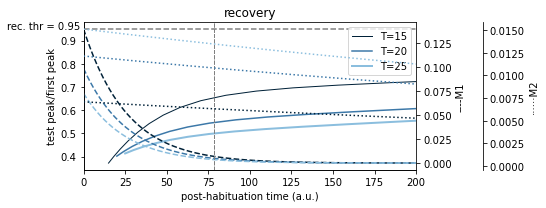

Intensity sensitivity
T 15 A 10 14 1558.39
T 15 A 20 32 2299.12
T 15 A 30 40 2607.61


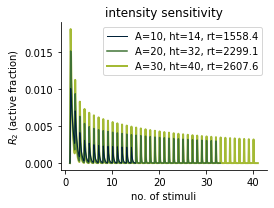

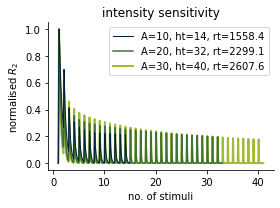

in plot trajectories, variables to plot ['I1', 'M1', 'R1', 'I2', 'M2']
setting ylims None


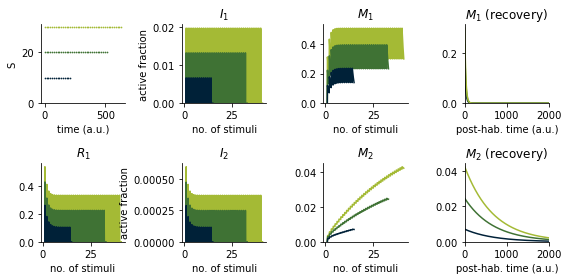

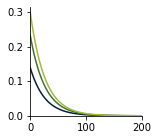

Potentiation
T 15 A 10
A 10 T 15 rt 1558.39 time at which new train applied is 779
True ht: 14 ht2: 10 rt: 1558.39 rt2: 615.5
amplitude last peak train 1: 0.002132781153654745 train 2: 0.002097495815196887


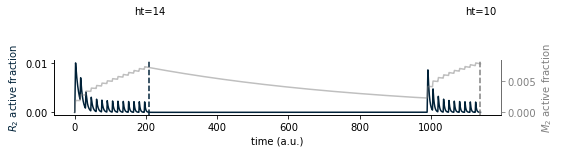

Subliminal
T 15 A 10
True ht: 14 ht2: 35 rt: 1558.39 rt2: 1911.16


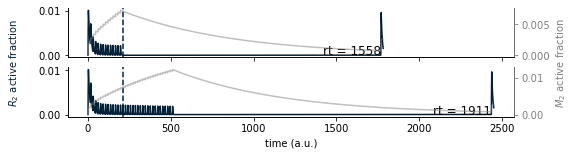

In [18]:
execute_and_plot(kwds)

In [ ]:
if False: #this shows that potentiation and subliminal accumulation are fulfilled for all combinations of T and A
    kwds["T_A_pot"]=[[T,A] for T in range(T_scan_set[0],T_scan_set[-1]+1,1) for A in range(A_scan_set[0],A_scan_set[-1]+1,1)]
    kwds["T_A_subliminal"]=[[T,A] for T in range(T_scan_set[0],T_scan_set[-1]+1,1) for A in range(A_scan_set[0],A_scan_set[-1]+1,1)]
    kwds["dopot"]=True
    kwds["printpotstatsonly"]=True
    kwds["dosubliminal"]=True
    kwds["printsubstatsonly"]=True
    execute_and_plot(kwds)

# Concatenated NF

In [11]:
def f_cNF(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2, K_2): 
    # starting values 
    I1, M1, R1, I2, M2, R2 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    dM1 = R1*kMa1*(1.0-M1) - kMi1*M1
    dI2 = R1*kIa2*(1.0-I2) - kIi2*I2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2/(K_2+R2)
    dM2 = R2*kMa2*(1.0-M2) - kMi2*M2

    return(dI1, dM1, dR1, dI2, dM2, dR2)
# set parameters


p0 = [0.230081, 33.9724, 0.0490086, 0.0211482, 7.74146, 18.194, 0.000690869, 
            0.0373467, 15.9387, 1.0256, 0.000423467, 7.50814, 22.3856, 1.14693]

idx_hab=5
idxM_pot=4
Amin=0

T_scan_set=[5,10,15]
A_scan_set = [10, 15, 20]
Sfs=15
Tis=10


X0 = [0,0,0,0,0,0] 

steps_per_time = 100





folder="../../habituation/2023_paper/figs/panels"
#folder=".."
basename="cNF"

sensdata="./sensitivity_feedback_concat/sensitivity_feedback.txt"
labels_pars=[r"$k_{Ia1}$", r"$k_{Ii1}$",r"$k_{Ma1}$",r"$k_{Mi1}$",r"$k_{Ra1}$",r"$k_{Ri1}$",r"$K_{R1}$",r"$k_{Ma2}$",r"$k_{Mi2}$",r"$k_{Ra2}$",r"$k_{Ri2}$",r"$K_{R2}$",r"$k_{Ia2}$",r"$k_{Ii2}$"]


kwds=dict()
kwds["f"]=f_cNF
kwds["basename"]="cNF"
kwds["hmax"]=0 #but inside execute_and_plot it is lowered in some cases
kwds["X0"]=X0
kwds["p0"]=p0
kwds["T_scan_set"]=T_scan_set
kwds["A_scan_set"]=A_scan_set
kwds["Sfs"]=Sfs
kwds["Tis"]=Tis
kwds["Ton"]=1.11
kwds["idx_hab"]=idx_hab
kwds["idxs_M"]=[1,4] #idxs of first and second memory species
kwds["Ms_toplot"]=["M1","M2"] #plot in recovery plot
kwds["variables_toplot"]=["I1", "M1", "R1", "I2", "M2"]
kwds["idxs"]={"I1":0, "M1":1, "R1":2, "I2":3, "M2":4, "R2":5}
kwds["labels_pars"]=labels_pars
kwds["vartitles"]=labels_vars

kwds["ht_threshold"]=0.01
kwds["recovery_threshold"]=0.95
kwds["height_peaks_r"]=0.001
kwds["folder"]=folder

kwds["idxM_pot"]=idxM_pot

kwds["ht_threshold2"]=0.005
kwds["sensdatatxt"]=sensdata

kwds["colorsf"]=colorsf
kwds["colorsi"]=colorsi
kwds["steps_per_time"]=steps_per_time
kwds["xlimrecfs1"]=7000
kwds["xlimrecfs2"]=400
kwds["xlimrecis1"]=7000
kwds["xlimrecis2"]=400
kwds["xlimrecenv"]=300


kwds["T_A_pot"]=[[T_scan_set[1],Sfs]]
kwds["T_A_subliminal"]=[[T_scan_set[1],Sfs]]
kwds["rtf_pot"]=0.3
    
kwds["dosensitivity"]=True
kwds["dofreqsensitivity"]=True
kwds["dorecovery"]=True
kwds["doisensitivity"]=True
kwds["dopot"]=True
kwds["dosubliminal"]=True



sensitivity analysis


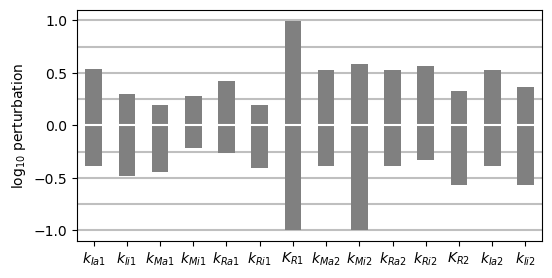

Frequency sensitivity
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.3738047616932D+04   r2 =  0.8829638137726D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.3738047616932D+04   r2 =  0.8829638137726D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.3738047616932D+04   r2 =  0.1446780309794D-12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.3738047616932D+04   r2 =  0.3616950774486D-13
 lsoda--  warn

/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A 15 T 10 18 7340.08
A 15 T 15 21 7697.07


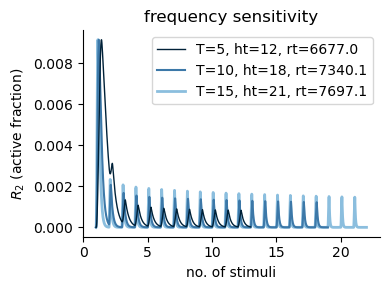

in plot trajectories, variables to plot ['I1', 'M1', 'R1', 'I2', 'M2']
setting ylims 16.5


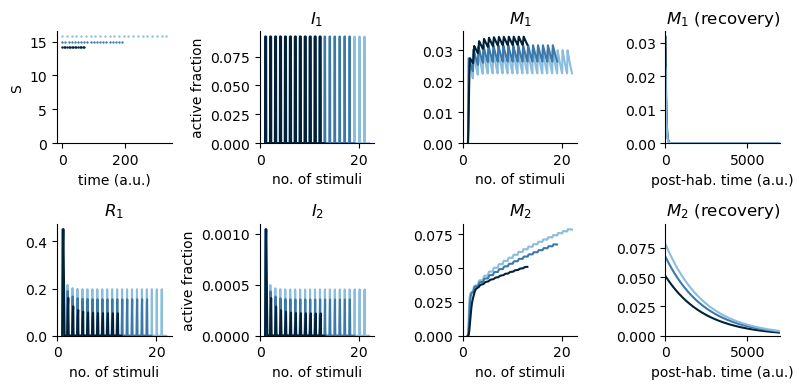

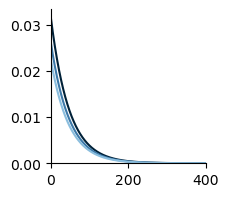

Recovery envelope
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.3738047616932D+04   r2 =  0.8829638137726D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.3738047616932D+04   r2 =  0.8829638137726D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.3738047616932D+04   r2 =  0.1446780309794D-12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.3738047616932D+04   r2 =  0.3616950774486D-13
 lsoda--  warning.

/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


5 M1 141.66
10 M1 141.66
15 M1 141.66


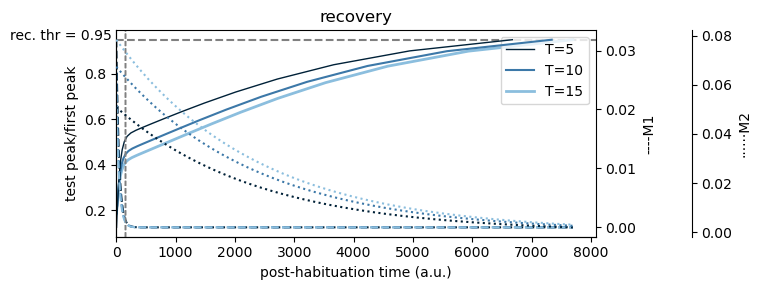

5 M1 141.66
10 M1 141.66
15 M1 141.66


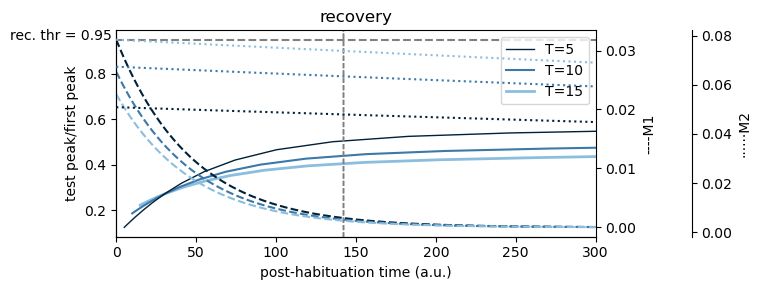

Intensity sensitivity
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276799999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276799999833D+05   r2 = -0.3276798999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276798999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276798999833D+05   r2 = -0.3276797999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276797999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276797999833D+05   r2 = -0.3276796999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276796999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276796999833D+05   r2 = -0.3276795999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276795999833D+05
      t not in interv

      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276619999833D+05   r2 = -0.3276618999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276618999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276618999833D+05   r2 = -0.3276617999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276617999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276617999833D+05   r2 = -0.3276616999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276616999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276616999833D+05   r2 = -0.3276615999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276615999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276615999833D+05   r2 = -0.3276614999833

 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276610999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276610999833D+05   r2 = -0.3276609999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276609999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276609999833D+05   r2 = -0.3276608999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276608999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276608999833D+05   r2 = -0.3276607999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276607999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276607999833D+05   r2 = -0.3276606999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276606999833D+05
      t not in interval tcur - hu (= r1) to

      in above,  r1 = -0.3276615999833D+05   r2 = -0.3276614999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276614999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276614999833D+05   r2 = -0.3276613999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276613999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276613999833D+05   r2 = -0.3276612999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276612999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276612999833D+05   r2 = -0.3276611999833D+05
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.3276611999833D+05
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.3276611999833D+05   r2 = -0.3276610999833D+05
 intdy--  t (=r1) illegal        
      in above message,

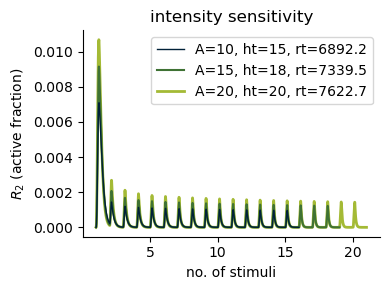

in plot trajectories, variables to plot ['I1', 'M1', 'R1', 'I2', 'M2']
setting ylims None


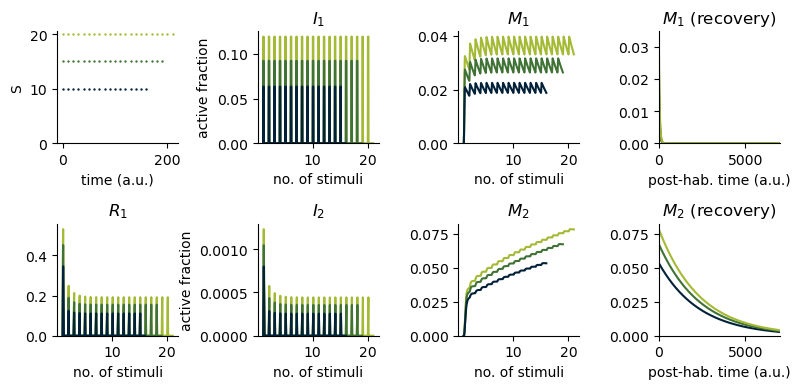

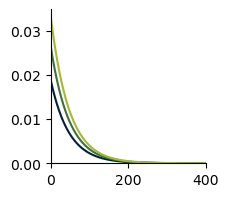

Potentiation
T 10 A 15
A 15 T 10 rt 7340.08 time at which new train applied is 2202
True ht: 18 ht2: 15 rt: 7340.08 rt2: 1864.73


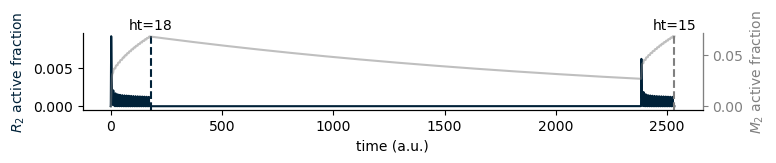

Subliminal
T 10 A 15
True ht: 18 ht2: 42 rt: 7340.08 rt2: 8070.26


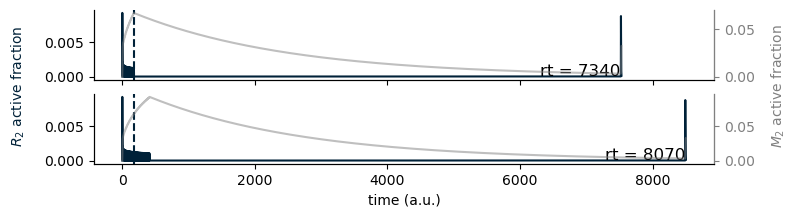

In [13]:

execute_and_plot(kwds)

# Receptor + IFF

In [16]:
def f_R_IFF(X, t, S, k1, k2, k3, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2):
    # starting values
    Ri, Rr, Ra, I2, M2, R2 = X

    dRi  = k3*Rr - k1*S*Ri
    dRa = S*k1*Ri - k2*Ra
    dRr = k2*Ra - k3*Rr 
    dI2 = Ra*kIa2*(1.0-I2) - kIi2*I2
    dM2 = I2*kMa2*(1.0-M2) - kMi2*M2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2 

    return(dRi, dRr, dRa, dI2, dM2, dR2)
# set parameters
labels_pars= [r"$k_{i}$", r"$k_{a}$", r"$k_{r}$", r"$k_{Ia2}$",r"$k_{Ii2}$",r"$k_{Ma2}$",r"$k_{Mi2}$",r"$k_{Ra2}$",r"$k_{Ri2}$"]
idx_hab=5
idxM_pot=4

p0 = [0.125459000, 1.497200000, 0.008299870 ,0.015193000, 11.204000000, 7.645580000 ,0.000790337, 25.958200000 ,36.517700000]

Ton=1.0
            

T_scan_set=[10,15,25]
A_scan_set = [2, 5, 15]
Sfs=5
Tis=25


X0 = [1,0,0,0,0,0] 

steps_per_time = 100


#mys = system.System(f_R_IFF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0.)



kwds=dict()
kwds["f"]=f_R_IFF
kwds["basename"]="f_R_IFF"
#kwds["mysystem"]=mys
kwds["X0"]=X0
kwds["p0"]=p0
kwds["hmax"]=0
kwds["T_scan_set"]=T_scan_set
kwds["A_scan_set"]=A_scan_set
kwds["Sfs"]=Sfs
kwds["Tis"]=Tis
kwds["Ton"]=Ton
kwds["idx_hab"]=idx_hab
kwds["idxs_M"]=[1,4] #idxs of first and second memory species
kwds["idxM_pot"]=idxM_pot
kwds["Ms_toplot"]=["Rr","M2"] #plot in recovery plot
kwds["variables_toplot"]=["Ri", "Rr", "Ra", "I2", "M2"]
kwds["idxs"]={"Ri":0, "Rr":1, "Ra":2, "I2":3, "M2":4, "R2":5}
kwds["labels_pars"]=labels_pars
kwds["vartitles"]=labels_vars

kwds["ht_threshold"]=0.01
kwds["recovery_threshold"]=0.95
kwds["height_peaks_r"]=0.001

kwds["folder"]=folder

kwds["ht_threshold2"]=0.005
kwds["sensdatatxt"]="./sensitivity_receptor_feedforward/sensitivity_receptor_feedforward.txt"

kwds["colorsf"]=colorsf
kwds["colorsi"]=colorsi
kwds["steps_per_time"]=steps_per_time
kwds["xlimrecfs1"]=7000
kwds["xlimrecfs2"]=400
kwds["xlimrecis1"]=7000
kwds["xlimrecis2"]=400
kwds["xlimrecenv"]=400


kwds["T_A_pot"]=[[T_scan_set[0],Sfs]]
kwds["T_A_subliminal"]=[[T_scan_set[0],Sfs]]
kwds["rtf_pot"]=0.5
    
kwds["dosensitivity"]=True
kwds["dofreqsensitivity"]=True
kwds["dorecovery"]=True
kwds["doisensitivity"]=True
kwds["dopot"]=True
kwds["dosubliminal"]=True

sensitivity analysis


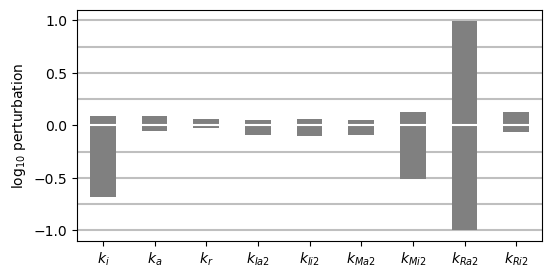

Frequency sensitivity
A 5 T 10 24 3340.2
A 5 T 15 28 3685.62
A 5 T 25 30 3993.16


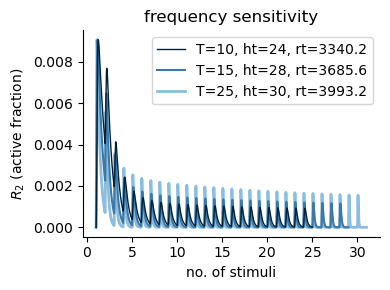

in plot trajectories, variables to plot ['Ri', 'Rr', 'Ra', 'I2', 'M2']
setting ylims 5.5


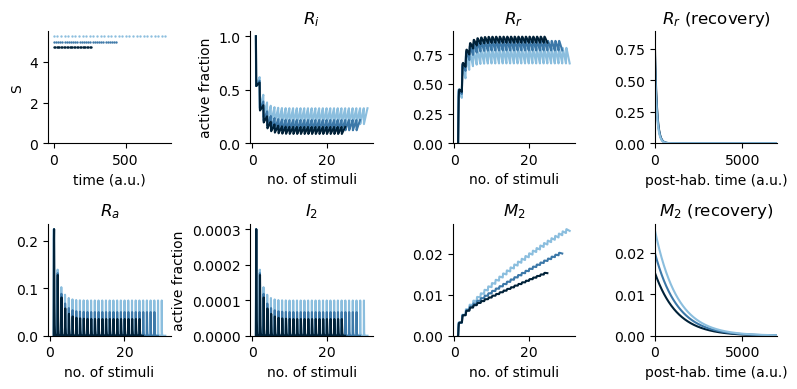

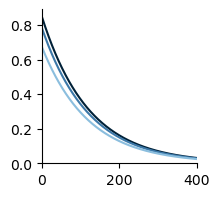

Recovery envelope
10 Rr 360.94
15 Rr 360.94
25 Rr 360.94


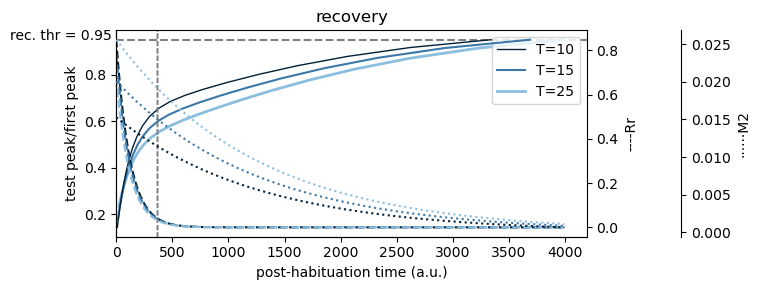

10 Rr 360.94
15 Rr 360.94
25 Rr 360.94


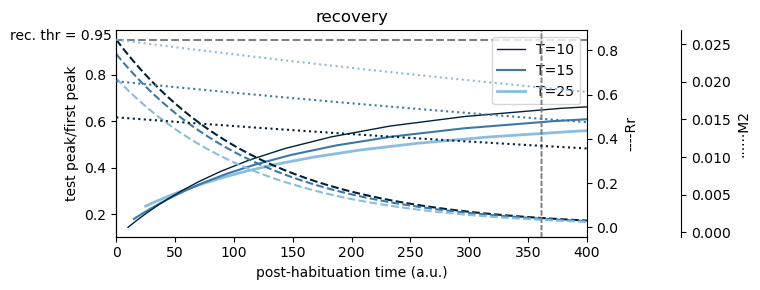

Intensity sensitivity
T 25 A 2 27 3783.7
T 25 A 5 30 3993.16
T 25 A 15 32 3982.92


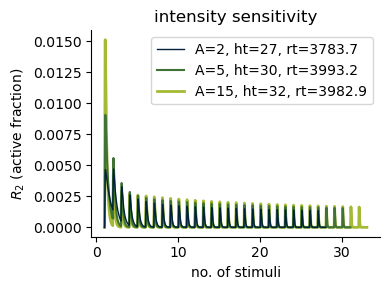

in plot trajectories, variables to plot ['Ri', 'Rr', 'Ra', 'I2', 'M2']
setting ylims None


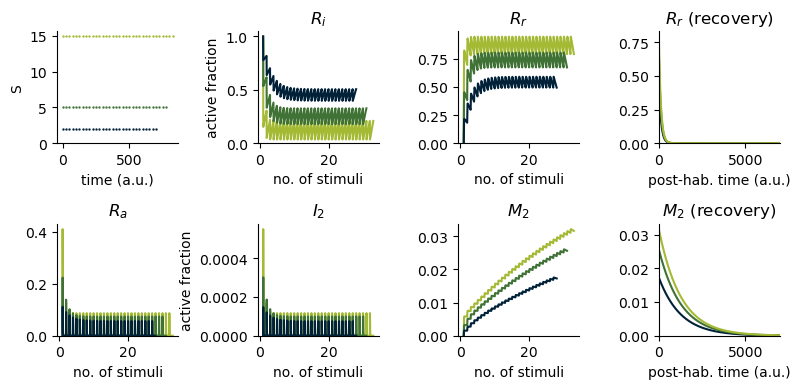

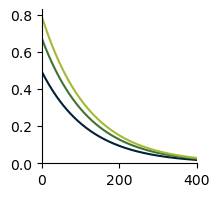

Potentiation
T 10 A 5
A 5 T 10 rt 3340.2 time at which new train applied is 1670
True ht: 24 ht2: 16 rt: 3340.2 rt2: 1312.35


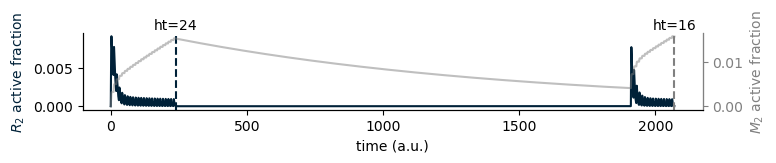

Subliminal
T 10 A 5
True ht: 24 ht2: 62 rt: 3340.2 rt2: 4079.7


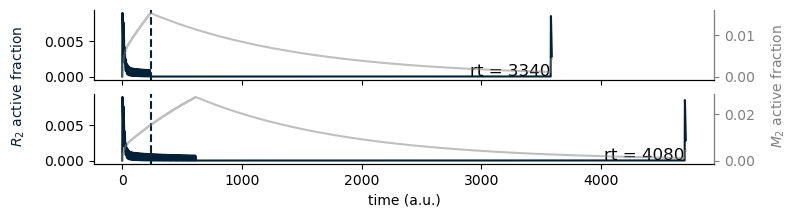

In [17]:

execute_and_plot(kwds)

A 2 T 10 26 3443.7


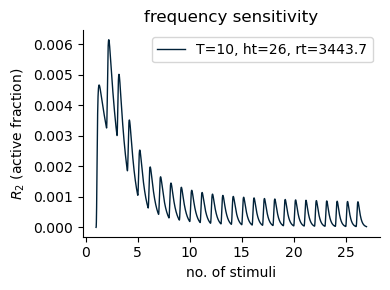

In [21]:
#A=2,T=10 sensitisation happens first. 
#Plot the freq sens - it does not hold but to see the sensitisation effect. Note that between lowest and highest T it does increase
Sfs=2
kwds2=kwds.copy()
kwds2["T_scan_set"]=[10]
kwds2["Sfs"]=Sfs

mys = system.System(f_R_IFF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0.)

output = execute_freq_sens(mys,Amax=Sfs,**kwds2)

savepath=None
plot_freq_or_is(*output,kind="freqs",colors=colorsf,**kwds2)


# Receptor-feedback

In [25]:

def f_R_NF(X, t, S, k1, k2, k3, kMa, kIa2, kIi2, kRa2, kRi2, kMa2, kMi2):
    # starting values
    Ri, Rr, Ra, I2, M2, R2 = X

    dRi  = k3*Rr - k1*S*Ri
    dRr = k2*Ra + kMa*M2*Ra - k3*Rr 
    dRa = S*k1*Ri - k2*Ra - kMa*M2*Ra
    dI2 = kIa2*Ra*(1-I2) - kIi2*I2
    dR2 = kRa2*I2*(1-R2) - kRi2*R2
    dM2 = kMa2*R2*(1-M2) - kMi2*M2
    
    return(dRi, dRr, dRa, dI2, dM2, dR2)



#["I1", "M1", "R1", "I2", "M2"]
variables_toplot=["Ri","Rr","I2","R2","M2"]
Ms_toplot=["Rr","M2"]
idxM_pot=4

p0=[ 0.123610, 0.772732, 0.104607, 0.903910, 1.033100, 5.04596, 1.002160, 5.75706, 2.51961, 0.000594] #only rates and ODE parameters
Ton=1.0

Amin=0
            

T_scan_set=[5,10,15]
A_scan_set = [3, 5, 10]
Sfs=10
Tis=10


X0 = [1,0,0,0,0,0] 

steps_per_time = 100


    

folder="../../habituation/2023_paper/figs/panels"
basename="R_F"
sensdata="./sensitivity_receptor_Ra/sensitivity_receptor_Ra.txt"
labels_pars= [r"$k_{i}$", r"$k_{a}$", r"$k_{r}$", r"$k_{FB}$",r"$k_{a1}$",r"$k_{i1}$",r"$k_{a2}$",r"$k_{i2}$",r"$k_{a3}$",r"$k_{i3}$"]

kwds=dict()
kwds["f"]=f_R_NF
kwds["hmax"]=0
kwds["basename"]="f_R_NF"
kwds["X0"]=X0
kwds["p0"]=p0
kwds["T_scan_set"]=T_scan_set
kwds["A_scan_set"]=A_scan_set
kwds["Sfs"]=Sfs
kwds["Tis"]=Tis
kwds["Ton"]=Ton
kwds["idx_hab"]=idx_hab
kwds["idxs_M"]=[1,4] #idxs of first and second memory species
kwds["idxM_pot"]=4
kwds["Ms_toplot"]=["Rr","M2"] #plot in recovery plot
kwds["variables_toplot"]=["Ri", "Rr", "Ra", "I2", "M2"]
kwds["idxs"]={"Ri":0, "Rr":1, "Ra":2, "I2":3, "M2":4, "R2":5}
kwds["labels_pars"]=labels_pars
kwds["vartitles"]=labels_vars

kwds["ht_threshold"]=0.01
kwds["recovery_threshold"]=0.95
kwds["height_peaks_r"]=0.001

kwds["folder"]=folder


kwds["ht_threshold2"]=0.005
kwds["sensdatatxt"]="./sensitivity_receptor_Ra/sensitivity_receptor_Ra.txt"

kwds["colorsf"]=colorsf
kwds["colorsi"]=colorsi
kwds["steps_per_time"]=steps_per_time
kwds["xlimrecfs1"]=7000
kwds["xlimrecfs2"]=100
kwds["xlimrecis1"]=7000
kwds["xlimrecis2"]=100
kwds["xlimrecenv"]=100

kwds["T_A_pot"]=[[T_scan_set[0],A_scan_set[2]]]
kwds["T_A_subliminal"]=[[T_scan_set[0],A_scan_set[2]]]
kwds["rtf_pot"]=0.5
    
kwds["dosensitivity"]=True
kwds["dofreqsensitivity"]=True
kwds["dorecovery"]=True
kwds["doisensitivity"]=True
kwds["dopot"]=True
kwds["dosubliminal"]=True

with 2 as output
sensitivity analysis


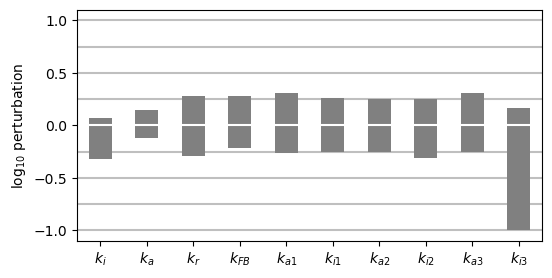

Frequency sensitivity
A 10 T 5 7 1271.8
A 10 T 10 9 1911.26
A 10 T 15 10 2153.34


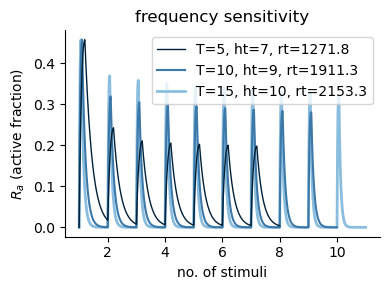

in plot trajectories, variables to plot ['Ri', 'Rr', 'Ra', 'I2', 'M2']
setting ylims 11.0


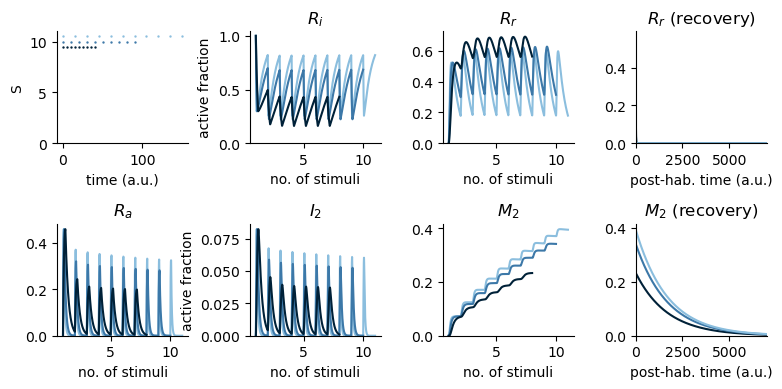

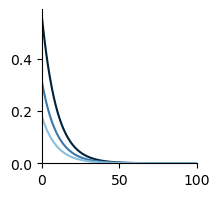

Recovery envelope
5 Rr 28.72
10 Rr 28.64
15 Rr 28.64


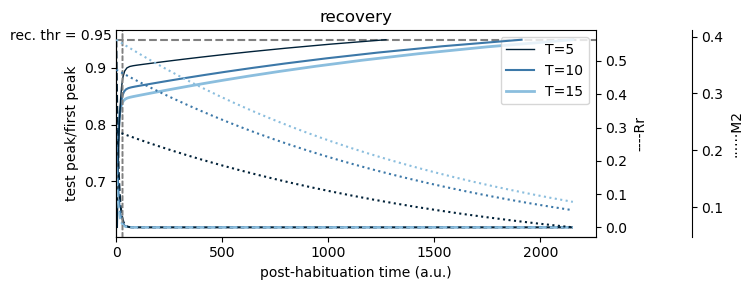

5 Rr 28.72
10 Rr 28.64
15 Rr 28.64


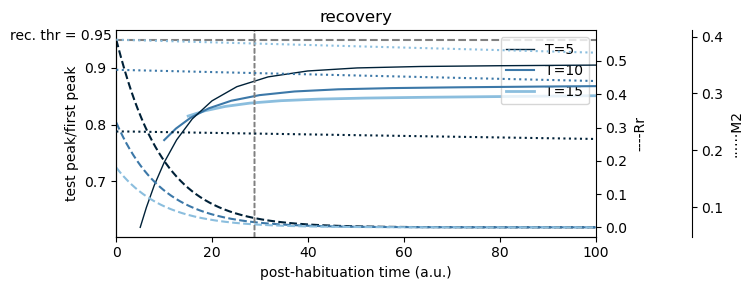

Intensity sensitivity
T 10 A 3 5 106.52
T 10 A 5 7 1074.64
T 10 A 10 9 1911.26


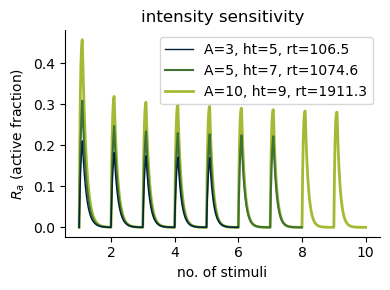

in plot trajectories, variables to plot ['Ri', 'Rr', 'Ra', 'I2', 'M2']
setting ylims None


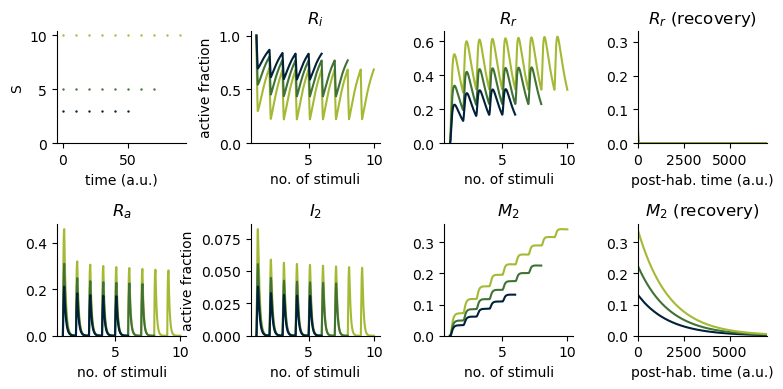

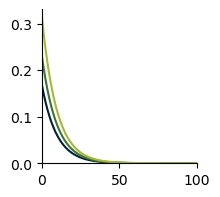

Potentiation
T 5 A 10
A 10 T 5 rt 1271.8 time at which new train applied is 635
True ht: 7 ht2: 5 rt: 1271.8 rt2: 102.35


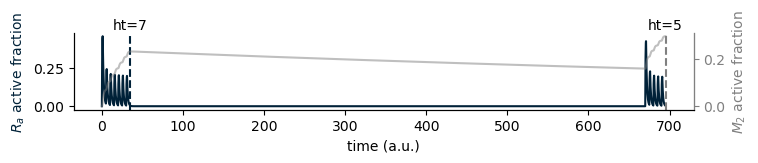

Subliminal
T 5 A 10
True ht: 7 ht2: 20 rt: 1271.8 rt2: 2368.17


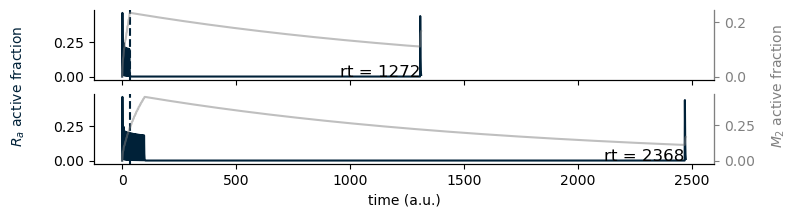

with 5 as output
Frequency sensitivity
A 10 T 5 5 588.48
A 10 T 10 7 1320.95
A 10 T 15 8 1608.3


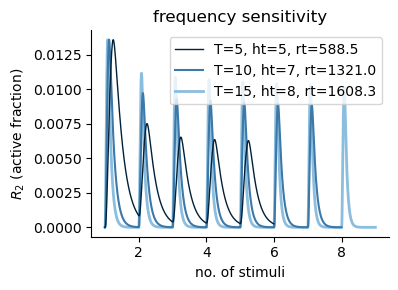

in plot trajectories, variables to plot ['Ri', 'Rr', 'Ra', 'I2', 'M2']
setting ylims 11.0


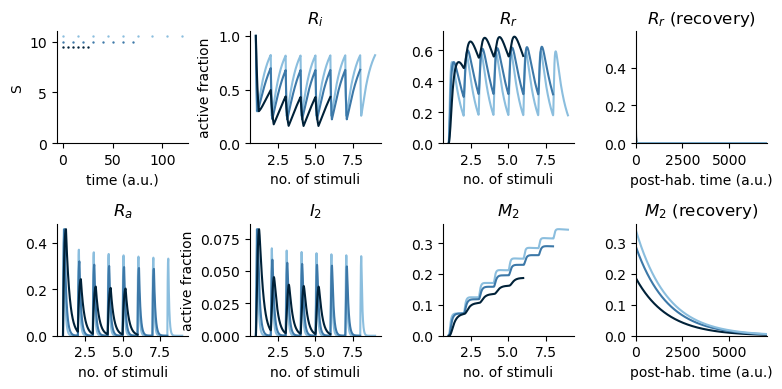

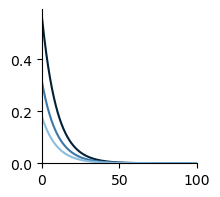

Recovery envelope
5 Rr 28.73
10 Rr 28.64
15 Rr 28.64


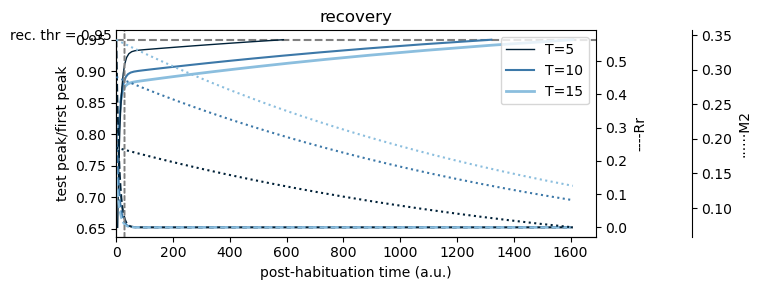

5 Rr 28.73
10 Rr 28.64
15 Rr 28.64


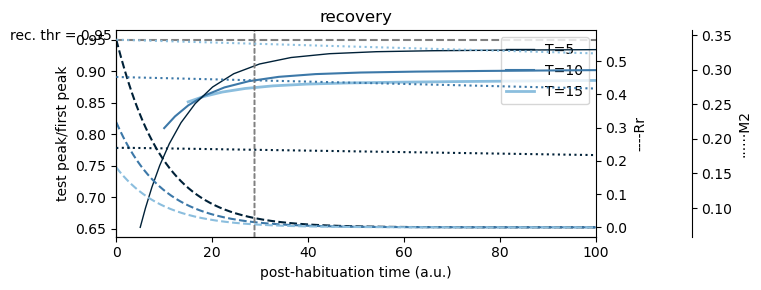

Intensity sensitivity
T 10 A 3 5 86.13
T 10 A 5 6 761.83
T 10 A 10 7 1320.95


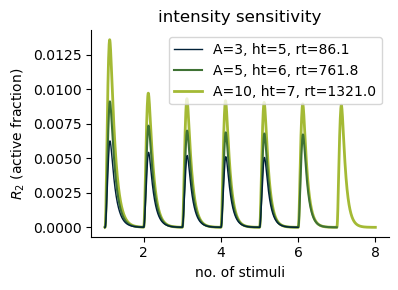

in plot trajectories, variables to plot ['Ri', 'Rr', 'Ra', 'I2', 'M2']
setting ylims None


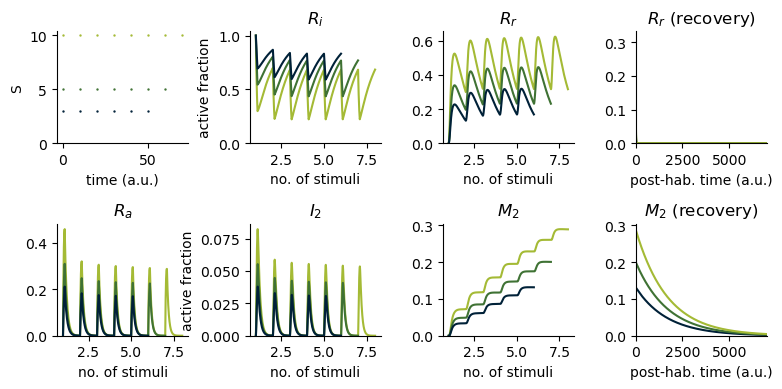

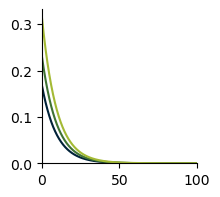

Potentiation
T 5 A 10
A 10 T 5 rt 588.48 time at which new train applied is 294
True ht: 5 ht2: 4 rt: 588.48 rt2: 38.0


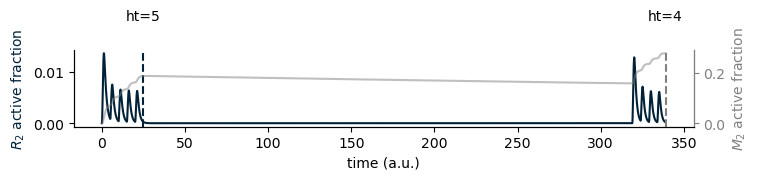

Subliminal
T 5 A 10
True ht: 5 ht2: 17 rt: 588.48 rt2: 1900.85


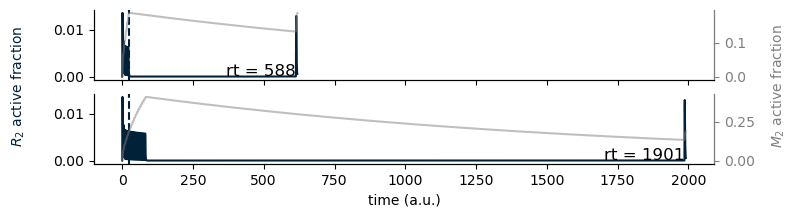

In [27]:
for idx_hab in [2,5]:
    
    kwds2=kwds.copy()
    kwds2["idx_hab"]=idx_hab
    kwds2["basename"]="R_F_%d"%idx_hab
    if idx_hab==5:
        kwds2["dosensitivity"]=False
    
    print("with %d as output"%idx_hab)
    execute_and_plot(kwds2)
    print("============")

# Single feedforward

Intensity sensitivity
T 5 A 4.51 18 109.1
T 5 A 9.02 20 118.08
T 5 A 13.52 22 122.3


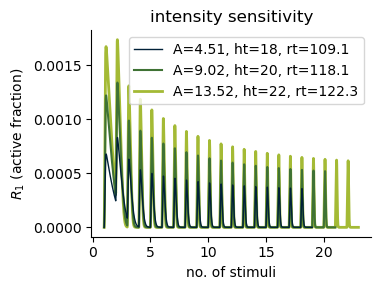

in plot trajectories, variables to plot ['I1', 'M1']
setting ylims None


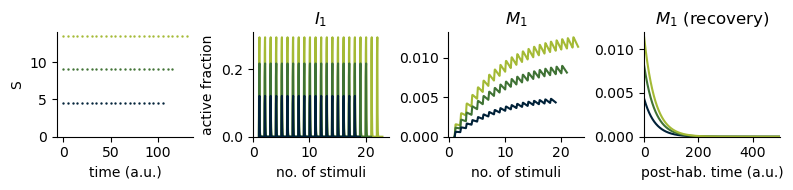

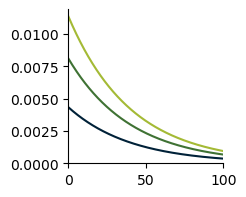

Potentiation
T 5 A 4.51
A 4.51 T 5 rt 109.1 time at which new train applied is 54
True ht: 18 ht2: 16 rt: 109.1 rt2: 43.7


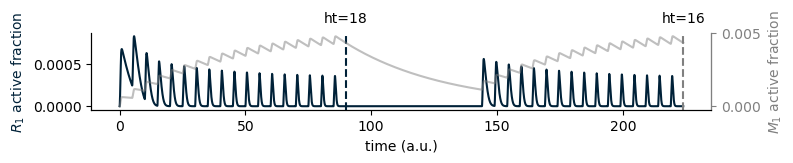

Subliminal
T 5 A 4.51
True ht: 18 ht2: 23 rt: 109.1 rt2: 111.2


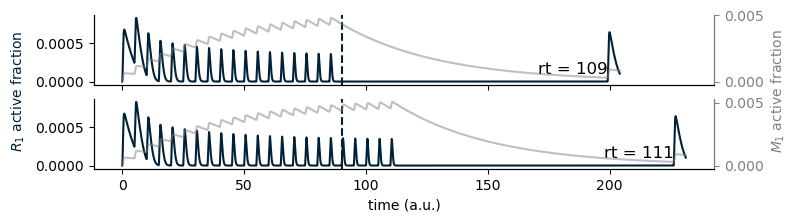

In [29]:
def f_IFF1(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1): 
    # starting values 
    I1, M1, R1 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)

    return(dI1, dM1, dR1)
# set parameters
 

p0=[ 0.21431239109526712, 6.847671424297533, 0.009953498338965153 , 0.024876350255001917, 
    0.011779374058405177, 0.30, 0.0002789402845197418] #only rates and ODE parameters
Ton= 0.5
Amin=0

T_scan_set=[5]
A_scan_set = [4.51, 9.02, 13.52]
Tis=T_scan_set[0]
Sfs=0


X0 = [0,0,0] 

labels=[r"$I_1$", r"$M_1$", r"$R_1$"] #should match order in X0

kwds=dict()
kwds["f"]=f_IFF1
kwds["basename"]="f_IFF1"
kwds["hmax"]=0
kwds["X0"]=X0
kwds["p0"]=p0
kwds["T_scan_set"]=T_scan_set
kwds["A_scan_set"]=A_scan_set
kwds["Sfs"]=Sfs
kwds["Tis"]=Tis
kwds["Ton"]=Ton
kwds["idx_hab"]=2
kwds["idxs_M"]=[1] #idxs of first and second memory species
kwds["Ms_toplot"]=["M1"] #plot in recovery plot
kwds["idxM_pot"]=1
kwds["variables_toplot"]=["I1", "M1"]
kwds["idxs"]={"I1":0, "M1":1, "R1":2}
kwds["labels_pars"]=labels_pars
kwds["vartitles"]=labels_vars

kwds["ht_threshold"]=0.01
kwds["recovery_threshold"]=0.95
kwds["height_peaks_r"]=0.001
kwds["folder"]=folder

kwds["ht_threshold2"]=0.005
kwds["sensdatatxt"]=""

kwds["colorsf"]=colorsf
kwds["colorsi"]=colorsi
kwds["steps_per_time"]=steps_per_time
kwds["xlimrecfs1"]=500
kwds["xlimrecfs2"]=100
kwds["xlimrecis1"]=500
kwds["xlimrecis2"]=100
kwds["xlimrecenv"]=200

kwds["T_A_pot"]=[[T_scan_set[0],A_scan_set[0]]]
kwds["T_A_subliminal"]=[[T_scan_set[0],A_scan_set[0]]]
kwds["rtf_pot"]=0.5
    
kwds["dosensitivity"]=False
kwds["dofreqsensitivity"]=False
kwds["dorecovery"]=False
kwds["doisensitivity"]=True
kwds["dopot"]=True
kwds["dosubliminal"]=True
execute_and_plot(kwds)

# Single feedback

Intensity sensitivity
T 5 A 2 7 100.12
T 5 A 4.5 8 108.32
T 5 A 9.0 9 113.67


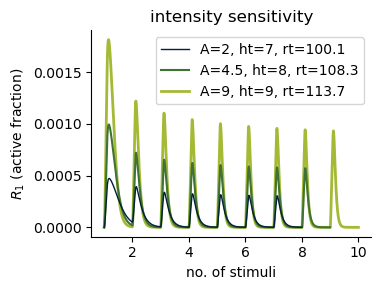

in plot trajectories, variables to plot ['I1', 'M1']
setting ylims None


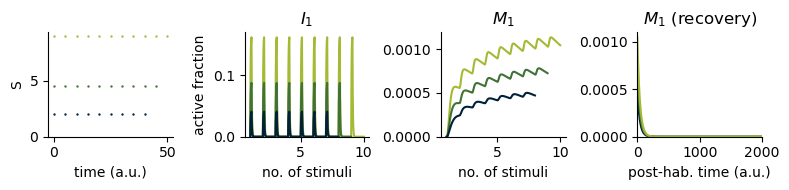

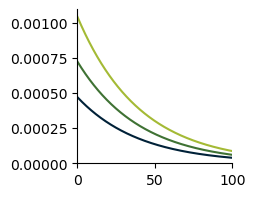

Potentiation
T 5 A 9.0
A 9.0 T 5 rt 113.67 time at which new train applied is 22
True ht: 9 ht2: 7 rt: 113.67 rt2: 16.2


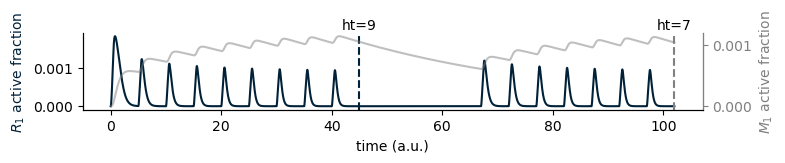

Subliminal
T 5 A 15
True ht: 9 ht2: 11 rt: 116.17 rt2: 116.89


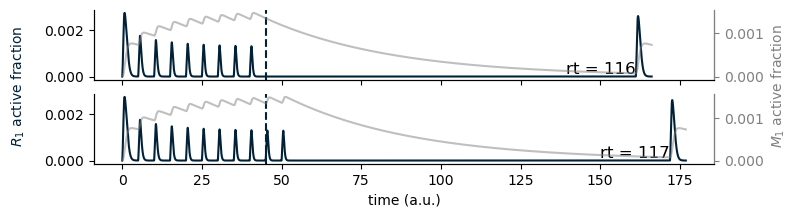

In [32]:
def f_NF(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1): 
    # starting values 
    I1, M1, R1 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = R1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    
    return(dI1, dM1, dR1)

p0=[ 0.15, 6.847671424297533, 0.21431239109526712 , 0.024876350255001917, 
    0.023558748116810354, 9.0, 0.002789402845197418] #only rates and ODE parameters
Ton= 0.5
Amin=0


X0 = [0,0,0] 

labels=[r"$I_1$", r"$M_1$", r"$R_1$"] #should match order in X0
idxs={"I1":0, "M1":1, "R1":2}
A_scan_set = [ 2,4.5,9.0]
#A_scan_set = [ 2,5,13]
T_scan_set=[5]
Sfs=0
T_is=T_scan_set[0]


kwds=dict()
kwds["f"]=f_NF
kwds["basename"]="f_NF1"
kwds["hmax"]=0
kwds["X0"]=X0
kwds["p0"]=p0
kwds["T_scan_set"]=T_scan_set
kwds["A_scan_set"]=A_scan_set
kwds["Sfs"]=Sfs
kwds["Tis"]=Tis
kwds["Ton"]=Ton
kwds["idx_hab"]=2
kwds["idxs_M"]=[1] #idxs of first and second memory species
kwds["Ms_toplot"]=["M1"] #plot in recovery plot
kwds["idxM_pot"]=1
kwds["variables_toplot"]=["I1", "M1"]
kwds["idxs"]={"I1":0, "M1":1, "R1":2}
kwds["labels_pars"]=labels_pars
kwds["vartitles"]=labels_vars

kwds["ht_threshold"]=0.01
kwds["recovery_threshold"]=0.95
kwds["folder"]=folder
kwds["height_peaks_r"]=0.001

kwds["ht_threshold2"]=0.005
kwds["sensdatatxt"]=""

kwds["colorsf"]=colorsf
kwds["colorsi"]=colorsi
kwds["steps_per_time"]=steps_per_time
kwds["xlimrecfs1"]=2000
kwds["xlimrecfs2"]=100
kwds["xlimrecis1"]=2000
kwds["xlimrecis2"]=100
kwds["xlimrecenv"]=100

kwds["T_A_pot"]=[[T_scan_set[0],A_scan_set[-1]]]
kwds["T_A_subliminal"]=[[T_scan_set[0],15]]
kwds["rtf_pot"]=0.2
    
kwds["dosensitivity"]=False
kwds["dofreqsensitivity"]=False
kwds["dorecovery"]=False
kwds["doisensitivity"]=True
kwds["dopot"]=True
kwds["dosubliminal"]=True
execute_and_plot(kwds)